In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existin

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import time
import timm
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.model_selection import train_test_split

![image.png](attachment:ae1db856-c35f-4dd3-939c-f8feeabcc56e.png)

In [ ]:
# path = '/kaggle/input/icdar2003'
# def extract_data_from_xml(root_dir):
#     xml_path = os.path.join(root_dir, 'words.xml')
#     tree = ET.parse(xml_path)
#     root = tree.getroot()

#     img_paths = []
#     img_sizes = []
#     img_labels = []
#     bboxes = []

#     for img in root:
#         bbs_of_img = []
#         labels_of_imgs = []

#         for bbs in img.findall('taggedRectangles'):
#             for bb in bbs:
#                 # check non-alphabet and non-number
#                 if not bb[0].text.isalnum():
#                     continue
#                 if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
#                     continue
                    
#                 bbs_of_img.append(
#                     [
#                         float(bb.attrib['x']),
#                         float(bb.attrib['y']),
#                         float(bb.attrib['width']),
#                         float(bb.attrib['height'])
#                     ]
#                 )
#                 labels_of_imgs.append(bb[0].text.lower())

#         img_path = os.path.join(root_dir, img[0].text)
#         img_paths.append(img_path)
#         img_sizes.append((int(img[1].attrib['x']), int(img[1].attrib['y'])))
#         bboxes.append(bbs_of_img)
#         img_labels.append(labels_of_imgs)
    
#     return img_paths, img_sizes, img_labels, bboxes

# dataset_dir = 'SceneTrialTrain'
# img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(os.path.join(path, dataset_dir))

# Data Preprocessing

In [3]:
def extract_data_from_textocr(json_path, image_root):
    with open(json_path, 'r') as f:
        data = json.load(f)

    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    imgs = data["imgs"]
    anns = data["anns"]

    # Track existing images by index to append to correct entry
    img_index_map = {}

    for ann_id, ann in anns.items():
        img_id = ann["image_id"]
        img_info = imgs[img_id]

        text = ann["utf8_string"].strip()
        if not text.isalnum() or ' ' in text:
            continue

        bbox = ann["bbox"]  # [x, y, width, height]
        img_path = os.path.join(image_root, img_info["file_name"].split('/')[1])

        if img_id not in img_index_map:
            # New image entry
            img_index = len(img_paths)
            img_index_map[img_id] = img_index
            img_paths.append(img_path)
            img_sizes.append((img_info["width"], img_info["height"]))
            bboxes.append([bbox])
            img_labels.append([text])
        else:
            idx = img_index_map[img_id]
            bboxes[idx].append(bbox)
            img_labels[idx].append(text)

    return img_paths, img_sizes, img_labels, bboxes

json_file = '/kaggle/input/textocr-text-extraction-from-images-dataset/TextOCR_0.1_train.json'
image_root = '/kaggle/input/textocr-text-extraction-from-images-dataset/train_val_images/train_images'

img_paths, img_sizes, img_labels, bboxes = extract_data_from_textocr(json_file, image_root)

In [4]:
def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    os.makedirs(save_dir, exist_ok = True)

    count = 0
    labels = []

    for img_path, img_label, bbs in zip(img_paths, img_labels, bboxes):
        img = Image.open(img_path)

        for label, bb in zip(img_label, bbs):
            # Crop image
            cropped_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))

            # Filter out if 90% of the cropped image is black or white
            if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
                continue
            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
                continue

            # Save image
            filename = f"{count:06d}.jpg"
            cropped_img.save(os.path.join(save_dir, filename))

            new_img_path = os.path.join(save_dir, filename)

            label = new_img_path + '\t' + label

            labels.append(label) #Append label to the list

            count += 1

    print(f'Created {count} images')

    # Write labels to a text file
    with open(os.path.join(save_dir, 'labels.txt'), 'w', encoding='utf-8') as f:
        for label in labels:
            f.write(f"{label}\n")

save_dir = 'datasets/ocr_dataset'
split_bounding_boxes(img_paths, img_labels, bboxes, save_dir)

Created 482767 images


In [5]:
save_dir = 'datasets/ocr_dataset'
root_dir = save_dir

img_paths = []
labels = []

# Read labels from text file
with open(os.path.join(root_dir, 'labels.txt'), 'r',encoding='utf-8' ) as f:
    for label in f:
        labels.append(label.strip().split('\t')[1])
        img_paths.append(label.strip().split('\t')[0])

print(f"Total images: {len(img_paths)}")
print(f'Total labels: {len(labels)}')

Total images: 482767
Total labels: 482767


In [6]:
new_img_paths = [img_paths[i] for i in range(200000)]
new_labels = [labels[i] for i in range(200000)]

img_paths = new_img_paths
labels = new_labels

In [7]:
letters = [char.split(".")[0] for char in labels]
letters = "".join(letters)
letters = sorted(list(set(list(letters))))

# Create a string for all characters in the dataset
chars = "".join(letters)

# For "Blank" characters
blank_char = "-"
chars += blank_char
vocab_size = len(chars)

print(f'Vocab: {chars}')
print(f'Vocab size: {vocab_size}')

Vocab: 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz²³µ¹¼½¾ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÑÒÓÔÕÖØÙÚÛÜÝßàáâãäåæçèéêëìíîïñòóôõöøùúûüýÿĀāĂăĄąĆćċČčĐĒēĖėęĚěġĩĪİıĺĽŁŃńňŉŌōŎőŒŘřŚśşŠšŢţŤũŪūŮůŰźŻżŽžƃƉƠơƬƯưǏǒǪǵȂȇȊȍȎȏȓȕȗțȮəɮʃʰˉˢˣΔΡΣΦΩίαβελνπστϋабвгдежиклмнопрстуъыьэײبرل٢٣ڮڽۊᴐᴰᴱᴴᴵᴸᴹᴺᵀᵃᵈᵉᵐᵒᵗᵛᶜᶻᶾḂḎḕḢḻṁṅṫẏẢẤẦầẬẮẶẾỀềỆọỐốồỘỢό⁰⁵⁷⁸⁹ⁿ₁₃₄ₓₘₙₜℇℒΩℱ⅓⅔ⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩⅪⅫ①②❶➀➁➂➃➄➅➋➌➍➎ⱽ卐ꝋ𝕵-
Vocab size: 354


In [8]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {index: char for char, index in char_to_idx.items()}

In [9]:
max_label_len = max([len(label) for label in labels])

def encode(label, char_to_idx, max_label_len):
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label], dtype=torch.long
    )
    label_len = len(encoded_labels)
    lengths = torch.tensor(label_len, dtype=torch.long)
    padded_labels = F.pad(encoded_labels, (0, max_label_len - label_len), value=0)

    return padded_labels, lengths

In [25]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None # To track the previous character

        for token in seq:
            if token != 0: # Ignore padding (token = 0)
                char = idx_to_char[token.item()]
                # Append the character if it ’s not a blank or the same as the previous character

                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char # Update previous character

        decoded_sequences.append("".join(decoded_label))
    #print(f"From {encoded_sequences} to {decoded_sequences}")
    
    return decoded_sequences


In [11]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(
                brightness=0.5,
                contrast=0.5,
                saturation=0.5,
            ),
            transforms.Grayscale(
                num_output_channels=1,
            ),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(
                degrees=1,
                shear=1,
            ),
            transforms.RandomPerspective(
                distortion_scale=0.3,
                p=0.5,
                interpolation=3,
            ),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

In [15]:
seed = 0
val_size = 0.2
test_size = 0.1
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths,
    labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

# X_val, X_test, y_val, y_test = train_test_split(
#     X_test,
#     y_test,
#     test_size=0.2,
#     # random_state = seed,
#     # shuffle = False,
# )

## Save Data (Optional)

In [16]:
torch.save({
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test,
    'char_to_idx': char_to_idx,
    'max_label_len': max_label_len
}, 'str_data.pt')

## Load data

In [12]:
data = torch.load('/kaggle/input/data2/other/default/1/str_data_2.pt')

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
char_to_idx = data['char_to_idx']
idx_to_char = {index: char for char, index in char_to_idx.items()}
max_label_len = data['max_label_len']

In [13]:
class STRDataset(Dataset):
    def __init__(self, X, Y, char_to_idx, max_label_len, label_encoder=None, transform=None):
        self.transform = transform
        self.img_paths = X
        self.labels = Y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label, self.char_to_idx, self.max_label_len
            )
        return img , encoded_label , label_len

In [14]:
train_dataset = STRDataset(
    X_train, y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['train']
)

val_dataset = STRDataset(
    X_val, y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)

test_dataset = STRDataset(
    X_test, y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)

train_batch_size = 64
test_batch_size = 64 * 2

train_loader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size = test_batch_size,
    shuffle = False,
)
test_loader = DataLoader (
    test_dataset ,
    batch_size = test_batch_size ,
    shuffle = False,
)

From tensor([[12, 31,  0,  ...,  0,  0,  0],
        [25, 16, 34,  ...,  0,  0,  0],
        [55, 52, 52,  ...,  0,  0,  0],
        ...,
        [12, 49, 58,  ...,  0,  0,  0],
        [ 4,  2,  3,  ...,  0,  0,  0],
        [15, 42, 49,  ...,  0,  0,  0]]) to ['AT', 'NEW', 'rom', 'CitySport', 'I', 'making', 'wal', 'HUYSE', 'that', 'STRAIGHT', 'kinderen', 'THIS', 'mach', 'hexametphosphate', 'CALAMBRE', 'Photos', 'away', 'z', 'Mop', '35', 'BABY', 'UST', '40', 'of', '70', '20', 'Content', 'fly', 'za', 'OLETI', 'Weisbier', 'your', 'CAUTION', 'al', 'TROUBLE', 'ONLY', 'OF', 'NETFLIX', 'NO', 'AUTO', 'zijn', 'cut', 'Harina', 'IN', '20', '7', 'from', 'BODEGAS', 'Poter', 'TACHYMETRE', 'W', 'estoy', 'Wings', 'Lichtstrahl', '2734302845', 'CONCAT', 'Pavilion¹⁵', 'N', 'Artisanal', 'Removable', 'CAOL', 'Alumni', '2013', 'Delete']
['AT', 'NEW', 'rom', 'CitySport', 'I', 'making', 'wal', 'HUYSE', 'that', 'STRAIGHT', 'kinderen', 'THIS', 'mach', 'hexametphosphate', 'CALAMBRE', 'Photos', 'away', 'z', 'Mo

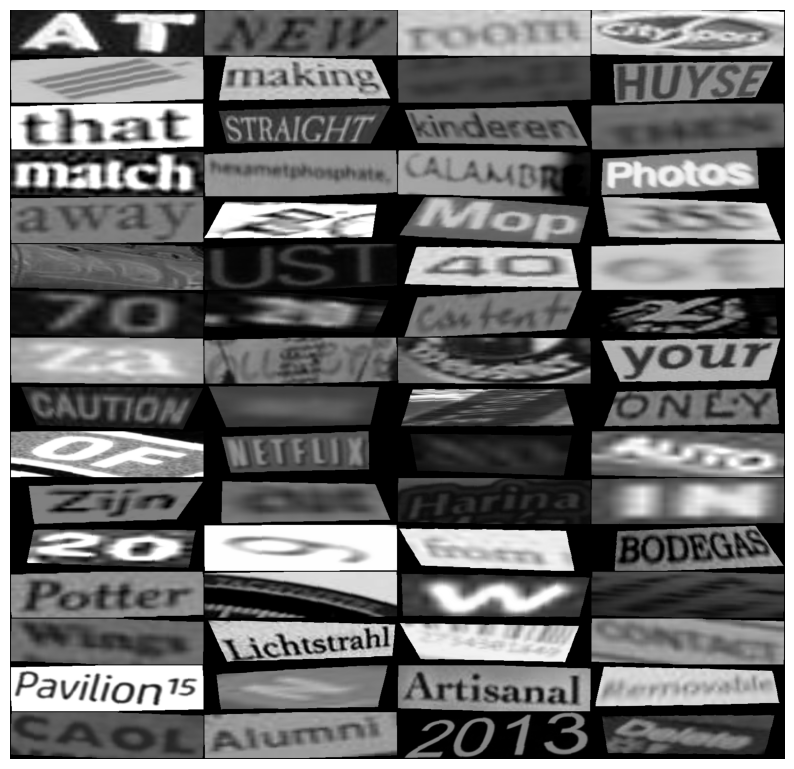

In [15]:
train_features, train_labels, train_lengths = next(iter(train_loader))


# use torchvision to display a grid of images
def show_batch(imgs, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")
    print(labels)
    plt.show()


show_batch(train_features, train_labels)

# CRNN architectures

## CRNN with YOLOv11-cls backbone

In [32]:
yolo_model

Sequential(
  (0): Conv(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (2): C3k2(
    (cv1): Conv(
      (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (cv2): Conv(
      (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (m): ModuleList(
      (0): C3k(
        (cv1): Conv(
          

In [27]:
yolo_model = YOLO('yolo11m-cls.pt').model.model

def convert_to_grayscale(model):
    conv1 = model[0].conv # or model.conv1, depending on your architecture
    if isinstance(conv1, nn.Conv2d) and conv1.in_channels == 3:
        new_conv = nn.Conv2d(
            1,
            conv1.out_channels,
            kernel_size=conv1.kernel_size,
            stride=conv1.stride,
            padding=conv1.padding,
            bias=conv1.bias is not None
        )
        # Optionally, average the weights across RGB channels for a better init
        with torch.no_grad():
            new_conv.weight[:] = conv1.weight.mean(dim=1, keepdim=True)
            if conv1.bias is not None:
                new_conv.bias[:] = conv1.bias
        model[0].conv = new_conv  # Or assign to model.conv1
    return model


class YOLOCRNN(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3
    ):
        super(YOLOCRNN, self).__init__()
        backbone = convert_to_grayscale(yolo_model)
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True
            
        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size), nn.LogSoftmax(dim=2)
        )
        
    @torch.autocast(device_type="cuda")
    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)  # Flatten the feature map
        x, _ = self.gru(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)  # Based on CTC

        return x


hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = YOLOCRNN(
    vocab_size = vocab_size,
    hidden_size = hidden_size,
    n_layers = n_layers,
    dropout = dropout_prob,
    unfreeze_layers = unfreeze_layers,
).to(device)

## CRNN with ResNet152 backbone

In [16]:
class CRNN(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        backbone = timm.create_model("resnet152", in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 512), nn.ReLU(), nn.Dropout(dropout)
        )

        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )

        # self.lstm = nn.LSTM(
        #     512,
        #     hidden_size,
        #     n_layers,
        #     bidirectional=True,
        #     batch_first=True,
        #     dropout=dropout if n_layers > 1 else 0,
        # )
        
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size), nn.LogSoftmax(dim=2)
        )

    @torch.autocast(device_type="cuda")
    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)  # Flatten the feature map
        x = self.mapSeq(x)
        x, _ = self.gru(x)
        # x, _ = self.lstm(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)  # Based on CTC

        return x

hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CRNN(
    vocab_size = vocab_size,
    hidden_size = hidden_size,
    n_layers = n_layers,
    dropout = dropout_prob,
    unfreeze_layers = unfreeze_layers,
).to(device)

model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

## Transformers

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.2, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)  # Even
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [B, T, D]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class Transformer(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3, n_heads=8
    ):
        super().__init__()

        # Backbone
        backbone = timm.create_model("resnet152", in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))  # [B, C, 1, W]
        self.backbone = nn.Sequential(*modules)

        for param in self.backbone[-unfreeze_layers:].parameters():
            param.requires_grad = True

        # Project features to hidden_size
        self.feature_proj = nn.Sequential(
            nn.Linear(2048, hidden_size), nn.ReLU(), nn.Dropout(dropout)
        )

        # Positional Encoding + Transformer Encoder
        self.pos_encoder = PositionalEncoding(hidden_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=n_heads,
            dim_feedforward=hidden_size * 4,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.layer_norm = nn.LayerNorm(hidden_size)
        self.out = nn.Sequential(
            nn.Linear(hidden_size, vocab_size),
            nn.LogSoftmax(dim=2),
        )

    @torch.autocast(device_type="cuda")
    def forward(self, x):
        x = self.backbone(x)                   # [B, 2048, 1, W]
        x = x.permute(0, 3, 1, 2).squeeze(3)   # [B, W, 2048]
        x = self.feature_proj(x)              # [B, W, hidden_size]
        x = self.pos_encoder(x)               # [B, W, hidden_size]
        x = self.transformer_encoder(x)       # [B, W, hidden_size]
        x = self.layer_norm(x)
        x = self.out(x)                       # [B, W, vocab_size]
        x = x.permute(1, 0, 2)                # [W, B, vocab_size] for CTC

        return x

In [16]:
# def evaluate(model, dataloader, criterion, device):
#     model.eval()
#     losses = []
#     with torch.no_grad():
#         for inputs, labels, labels_len in dataloader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             labels_len = labels_len.to(device)

#             outputs = model(inputs)
#             logits_lens = torch.full(
#                 size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long
#             ).to(device)

#             loss = criterion(outputs, labels, logits_lens, labels_len)
#             losses.append(loss.item())

#     loss = sum(losses) / len(losses)

#     return loss

# def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, val_losses, path="checkpoint.pt"):
#     torch.save({
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'scheduler_state_dict': scheduler.state_dict(),
#         'train_losses': train_losses,
#         'val_losses': val_losses
#     }, path)

# from tqdm import tqdm
# import time

# def fit(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, start_epoch=0):
#     train_losses = []
#     val_losses = []
#     best_val_loss = float('inf')  # Track best val loss

#     for epoch in range(start_epoch, epochs):
#         start = time.time()
#         batch_train_losses = []

#         model.train()
#         loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
#         for idx, (inputs, labels, labels_len) in enumerate(loop):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(inputs)

#             logits_lens = torch.full(
#                 size=(outputs.size(1),),
#                 fill_value=outputs.size(0),
#                 dtype=torch.long,
#             ).to(device)

#             loss = criterion(outputs, labels, logits_lens, labels_len)
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
#             optimizer.step()

#             batch_train_losses.append(loss.item())
#             loop.set_postfix(loss=loss.item())

#         train_loss = sum(batch_train_losses) / len(batch_train_losses)
#         train_losses.append(train_loss)

#         val_loss = evaluate(model, val_loader, criterion, device)
#         val_losses.append(val_loss)

#         print(f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\t\t Time: {time.time() - start:.2f} seconds")
#         scheduler.step()

#         # Save checkpoint if validation loss improves
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'val_loss': val_loss
#             }, 'checkpoint.pt')
#             print(f"✅ Saved best model at epoch {epoch+1} with val_loss: {val_loss:.4f}")
#         torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'val_loss': val_loss
#         }, 'last.pt')

#     return train_losses, val_losses

In [17]:
def evaluate(model, dataloader, criterion, device):
    #model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels, labels_len in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            logits_lens = torch.full(
                size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

def save_checkpoint(epoch, model, optimizer, scheduler, train_loss, val_loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss
    }, path)

def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs, s1, s2, start_epoch=0):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')  # Track best val loss

    for epoch in range(start_epoch, epochs):
        start = time.time()
        batch_train_losses = []

        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for idx, (inputs, labels, labels_len) in enumerate(loop):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long,
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

            batch_train_losses.append(loss.item())
            loop.set_postfix(loss=loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\t\t Time: {time.time() - start:.2f} seconds")
        if epoch < 5:
            s1.step()
            scheduler = s1
        else:
            s2.step(val_loss)
            scheduler = s2

        
        # Save the best result
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(epoch, model, optimizer, scheduler, train_loss, val_loss, 'best.pt')
            print(f"✅ Saved best model at epoch {epoch+1} with val_loss: {val_loss:.4f}")  

        # Save checkpoint each epoch
        save_checkpoint(epoch, model, optimizer, scheduler, train_loss, val_loss, 'last.pt')
        print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
    return train_losses, val_losses

In [17]:
# epochs = 100
# lr = 5e-4
# weight_decay = 1e-5
# scheduler_step_size = epochs * 0.5

# criterion = nn.CTCLoss (
#     blank = char_to_idx[blank_char],
#     zero_infinity = True,
#     reduction = "mean",
# )
# optimizer = torch.optim.Adam (
#     model.parameters() ,
#     lr = lr,
#     weight_decay = weight_decay
# )
# scheduler = torch.optim.lr_scheduler.StepLR (
#     optimizer , step_size = scheduler_step_size , gamma = 0.1
# )

In [18]:
epochs = 100
lr = 1e-3
weight_decay = 1e-5
#scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss (
    blank = char_to_idx[blank_char],
    zero_infinity = True,
    reduction = "mean",
)
optimizer = torch.optim.Adam (
    model.parameters() ,
    lr = lr,
    weight_decay = weight_decay
)
# scheduler = torch.optim.lr_scheduler.StepLR (
#     optimizer , step_size = scheduler_step_size , gamma = 0.1
# )
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau

# Warmup for first few epochs
def warmup_lambda(epoch):
    warmup_epochs = 5
    return min(1.0, (epoch + 1) / warmup_epochs)

warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)

# Adaptive scheduler for after warmup
plateau_scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Training Sequences

## CRNN with ResNet152 backbone + Bidirectional GRU (100k images)

In [28]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    warmup_scheduler,
    plateau_scheduler
)

# Epoch: 100, Optimizer: Adam, LR: 5e-4, LR scheduler: ReduceLROnPlateau

EPOCH 1:	Train loss: 1.3968	Val loss: 1.1835		 Time: 1232.05 seconds
✅ Saved best model at epoch 1 with val_loss: 1.1835


EPOCH 2:	Train loss: 1.2181	Val loss: 1.1065		 Time: 1229.70 seconds
✅ Saved best model at epoch 2 with val_loss: 1.1065


EPOCH 3:	Train loss: 1.1137	Val loss: 1.0847		 Time: 1227.64 seconds
✅ Saved best model at epoch 3 with val_loss: 1.0847


EPOCH 4:	Train loss: 1.0588	Val loss: 1.0791		 Time: 1227.20 seconds
✅ Saved best model at epoch 4 with val_loss: 1.0791


EPOCH 5:	Train loss: 1.0224	Val loss: 1.1118		 Time: 1225.01 seconds


EPOCH 6:	Train loss: 0.9548	Val loss: 1.0019		 Time: 1225.80 seconds
✅ Saved best model at epoch 6 with val_loss: 1.0019


EPOCH 7:	Train loss: 0.9021	Val loss: 1.0327		 Time: 1229.80 seconds


EPOCH 8:	Train loss: 0.8576	Val loss: 1.0480		 Time: 1229.97 seconds


EPOCH 9:	Train loss: 0.8191	Val loss: 0.9895		 Time: 1227.96 seconds
✅ Saved best model at epoch 9 with val_loss: 0.9895


EPOCH 10:	Train loss: 0.7876	Val loss: 0.9914		 Time: 1226.11 seconds


EPOCH 11:	Train loss: 0.7646	Val loss: 0.9629		 Time: 1228.65 seconds
✅ Saved best model at epoch 11 with val_loss: 0.9629


EPOCH 12:	Train loss: 0.7320	Val loss: 0.9443		 Time: 1227.23 seconds
✅ Saved best model at epoch 12 with val_loss: 0.9443


EPOCH 13:	Train loss: 0.7037	Val loss: 0.9540		 Time: 1226.65 seconds


EPOCH 14:	Train loss: 0.6840	Val loss: 0.9259		 Time: 1226.32 seconds
✅ Saved best model at epoch 14 with val_loss: 0.9259


EPOCH 15:	Train loss: 0.6725	Val loss: 0.9550		 Time: 1226.45 seconds


EPOCH 16:	Train loss: 0.6436	Val loss: 0.9036		 Time: 1226.11 seconds
✅ Saved best model at epoch 16 with val_loss: 0.9036


EPOCH 17:	Train loss: 0.6315	Val loss: 0.9239		 Time: 1226.30 seconds


EPOCH 18:	Train loss: 0.6163	Val loss: 0.9987		 Time: 1224.31 seconds


EPOCH 19:	Train loss: 0.6062	Val loss: 0.9234		 Time: 1224.52 seconds


EPOCH 20:	Train loss: 0.5800	Val loss: 0.9188		 Time: 1227.32 seconds


EPOCH 21:	Train loss: 0.5771	Val loss: 0.9123		 Time: 1225.11 seconds


EPOCH 22:	Train loss: 0.5534	Val loss: 0.9063		 Time: 1224.25 seconds


EPOCH 23:	Train loss: 0.4295	Val loss: 0.8374		 Time: 1225.29 seconds
✅ Saved best model at epoch 23 with val_loss: 0.8374


EPOCH 24:	Train loss: 0.3890	Val loss: 0.8447		 Time: 1229.06 seconds


EPOCH 25:	Train loss: 0.3709	Val loss: 0.8656		 Time: 1226.88 seconds


EPOCH 26:	Train loss: 0.3589	Val loss: 0.8755		 Time: 1226.53 seconds


EPOCH 27:	Train loss: 0.3471	Val loss: 0.8669		 Time: 1223.61 seconds


EPOCH 28:	Train loss: 0.3382	Val loss: 0.9178		 Time: 1224.75 seconds


EPOCH 29:	Train loss: 0.3284	Val loss: 0.8940		 Time: 1222.10 seconds


EPOCH 30:	Train loss: 0.2703	Val loss: 0.8485		 Time: 1224.20 seconds


EPOCH 31:	Train loss: 0.2468	Val loss: 0.8567		 Time: 1225.99 seconds


EPOCH 32:	Train loss: 0.2372	Val loss: 0.8762		 Time: 1224.09 seconds


EPOCH 33:	Train loss: 0.2271	Val loss: 0.8784		 Time: 1223.04 seconds


KeyboardInterrupt: 

In [20]:
checkpoint = torch.load('/kaggle/input/checkpoint/pytorch/default/1/checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs,
    start_epoch
)

/tmp/ipykernel_31/608865842.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/checkpoint/pytorch/default/1/checkpoint.pt')


EPOCH 14:	Train loss: 0.6718	Val loss: 0.9527		 Time: 1249.87 seconds
✅ Saved best model at epoch 14 with val_loss: 0.9527


EPOCH 15:	Train loss: 0.6571	Val loss: 0.9281		 Time: 1244.52 seconds
✅ Saved best model at epoch 15 with val_loss: 0.9281


EPOCH 16:	Train loss: 0.6436	Val loss: 1.0314		 Time: 1249.28 seconds


EPOCH 17:	Train loss: 0.6242	Val loss: 0.9147		 Time: 1245.46 seconds
✅ Saved best model at epoch 17 with val_loss: 0.9147


EPOCH 18:	Train loss: 0.6035	Val loss: 0.9314		 Time: 1244.91 seconds


EPOCH 19:	Train loss: 0.5936	Val loss: 0.9619		 Time: 1239.77 seconds


EPOCH 20:	Train loss: 0.5870	Val loss: 0.9235		 Time: 1237.62 seconds


EPOCH 21:	Train loss: 0.5711	Val loss: 0.9238		 Time: 1239.74 seconds


EPOCH 22:	Train loss: 0.5548	Val loss: 0.9386		 Time: 1239.12 seconds


EPOCH 23:	Train loss: 0.5459	Val loss: 0.9491		 Time: 1249.72 seconds


EPOCH 24:	Train loss: 0.5324	Val loss: 1.0742		 Time: 1244.92 seconds


EPOCH 25:	Train loss: 0.5307	Val loss: 0.9803		 Time: 1240.86 seconds


EPOCH 26:	Train loss: 0.5173	Val loss: 0.9822		 Time: 1239.82 seconds


EPOCH 27:	Train loss: 0.5088	Val loss: 1.1093		 Time: 1240.84 seconds


KeyboardInterrupt: 

In [24]:
checkpoint = torch.load('/kaggle/input/checkpoint/pytorch/default/1/best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
plateau_scheduler = checkpoint['scheduler']
start_epoch = checkpoint['epoch'] + 1

train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    warmup_scheduler,
    plateau_scheduler,
    start_epoch
)

/tmp/ipykernel_31/459348959.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/checkpoint/pytorch/default/1/best.pt')


EPOCH 24:	Train loss: 0.3902	Val loss: 0.9141		 Time: 1208.39 seconds
✅ Saved best model at epoch 24 with val_loss: 0.9141


KeyboardInterrupt: 

## CRNN + ResNet152 backbone + Bidirectional GRU (200k images)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    warmup_scheduler,
    plateau_scheduler
)


EPOCH 1:	Train loss: 2.5098	Val loss: 1.3065		 Time: 2515.70 seconds
✅ Saved best model at epoch 1 with val_loss: 1.3065
Current learning rate: 0.0002


EPOCH 2:	Train loss: 1.2933	Val loss: 1.1010		 Time: 2506.87 seconds
✅ Saved best model at epoch 2 with val_loss: 1.1010
Current learning rate: 0.0003


EPOCH 3:	Train loss: 1.1286	Val loss: 1.0440		 Time: 2503.01 seconds
✅ Saved best model at epoch 3 with val_loss: 1.0440
Current learning rate: 0.0004


EPOCH 4:	Train loss: 1.0650	Val loss: 1.0395		 Time: 2504.33 seconds
✅ Saved best model at epoch 4 with val_loss: 1.0395
Current learning rate: 0.0005


EPOCH 5:	Train loss: 1.0423	Val loss: 1.0354		 Time: 2537.80 seconds
✅ Saved best model at epoch 5 with val_loss: 1.0354
Current learning rate: 0.0005


EPOCH 6:	Train loss: 0.9874	Val loss: 1.0550		 Time: 2538.57 seconds
Current learning rate: 0.0005


EPOCH 7:	Train loss: 0.9352	Val loss: 0.9916		 Time: 2519.46 seconds
✅ Saved best model at epoch 7 with val_loss: 0.9916
Current learning rate: 0.0005


EPOCH 8:	Train loss: 0.9005	Val loss: 1.0218		 Time: 2500.76 seconds
Current learning rate: 0.0005


EPOCH 9:	Train loss: 0.8663	Val loss: 0.9976		 Time: 2519.55 seconds
Current learning rate: 0.0005


EPOCH 10:	Train loss: 0.8393	Val loss: 0.9308		 Time: 2517.26 seconds
✅ Saved best model at epoch 10 with val_loss: 0.9308
Current learning rate: 0.0005


Epoch 11/100:  86%|████████▋ | 1946/2250 [33:25<05:12,  1.03s/it, loss=1.1]  

In [ ]:
checkpoint = torch.load('/kaggle/input/checkpoint2/pytorch/default/1/best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
plateau_scheduler.load_state_dict(checkpoint['scheduler'])
start_epoch = checkpoint['epoch'] + 1

train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    warmup_scheduler,
    plateau_scheduler,
    start_epoch
)

/tmp/ipykernel_31/3647143859.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/checkpoint2/pytorch/default/1/best.pt')


EPOCH 15:	Train loss: 0.7414	Val loss: 0.9224		 Time: 2397.37 seconds
✅ Saved best model at epoch 15 with val_loss: 0.9224
Current learning rate: 0.0005


EPOCH 16:	Train loss: 0.7273	Val loss: 0.9255		 Time: 2376.99 seconds
Current learning rate: 0.0005


EPOCH 17:	Train loss: 0.7087	Val loss: 0.8750		 Time: 2406.67 seconds
✅ Saved best model at epoch 17 with val_loss: 0.8750
Current learning rate: 0.0005


EPOCH 18:	Train loss: 0.6949	Val loss: 0.9017		 Time: 2403.44 seconds
Current learning rate: 0.0005


EPOCH 19:	Train loss: 0.6838	Val loss: 0.8841		 Time: 2366.90 seconds
Current learning rate: 0.0005


EPOCH 20:	Train loss: 0.6689	Val loss: 0.8938		 Time: 2379.19 seconds
Current learning rate: 0.0005


EPOCH 21:	Train loss: 0.6640	Val loss: 0.9232		 Time: 2372.24 seconds
Current learning rate: 0.00025


EPOCH 22:	Train loss: 0.5332	Val loss: 0.7948		 Time: 2354.56 seconds
✅ Saved best model at epoch 22 with val_loss: 0.7948
Current learning rate: 0.00025


EPOCH 23:	Train loss: 0.4903	Val loss: 0.8004		 Time: 2372.88 seconds
Current learning rate: 0.00025


EPOCH 24:	Train loss: 0.4730	Val loss: 0.8162		 Time: 2372.92 seconds
Current learning rate: 0.00025


EPOCH 25:	Train loss: 0.4562	Val loss: 0.8046		 Time: 2355.65 seconds
Current learning rate: 0.00025


EPOCH 26:	Train loss: 0.4406	Val loss: 0.8048		 Time: 2378.00 seconds
Current learning rate: 0.000125


EPOCH 27:	Train loss: 0.3759	Val loss: 0.7508		 Time: 2372.01 seconds
✅ Saved best model at epoch 27 with val_loss: 0.7508
Current learning rate: 0.000125


EPOCH 28:	Train loss: 0.3475	Val loss: 0.7656		 Time: 2369.60 seconds
Current learning rate: 0.000125


EPOCH 29:	Train loss: 0.3365	Val loss: 0.7962		 Time: 2378.39 seconds
Current learning rate: 0.000125


EPOCH 30:	Train loss: 0.3247	Val loss: 0.7748		 Time: 2361.59 seconds
Current learning rate: 0.000125


EPOCH 31:	Train loss: 0.3127	Val loss: 0.7928		 Time: 2355.88 seconds
Current learning rate: 6.25e-05


Epoch 32/100:  89%|████████▉ | 2012/2250 [32:30<03:48,  1.04it/s, loss=0.302] 

In [ ]:
checkpoint = torch.load('/kaggle/input/checkpoint/pytorch/default/1/best_4.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
plateau_scheduler.load_state_dict(checkpoint['scheduler'])
start_epoch = checkpoint['epoch'] + 1

train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    warmup_scheduler,
    plateau_scheduler,
    start_epoch
)

EPOCH 28:	Train loss: 0.3493	Val loss: 0.7748		 Time: 2503.11 seconds
✅ Saved best model at epoch 28 with val_loss: 0.7748
Current learning rate: 0.000125


EPOCH 29:	Train loss: 0.3323	Val loss: 0.7831		 Time: 2506.89 seconds
Current learning rate: 0.000125


EPOCH 30:	Train loss: 0.3239	Val loss: 0.7911		 Time: 2499.39 seconds
Current learning rate: 0.000125


EPOCH 31:	Train loss: 0.3135	Val loss: 0.7889		 Time: 2496.45 seconds
Current learning rate: 6.25e-05


EPOCH 32:	Train loss: 0.2833	Val loss: 0.7859		 Time: 2498.74 seconds
Current learning rate: 6.25e-05


EPOCH 33:	Train loss: 0.2673	Val loss: 0.7955		 Time: 2498.86 seconds
Current learning rate: 6.25e-05


EPOCH 34:	Train loss: 0.2599	Val loss: 0.7932		 Time: 2505.33 seconds
Current learning rate: 6.25e-05


EPOCH 35:	Train loss: 0.2520	Val loss: 0.8020		 Time: 2500.17 seconds
Current learning rate: 3.125e-05


EPOCH 36:	Train loss: 0.2350	Val loss: 0.7977		 Time: 2503.75 seconds
Current learning rate: 3.125e-05


EPOCH 37:	Train loss: 0.2300	Val loss: 0.7992		 Time: 2505.10 seconds
Current learning rate: 3.125e-05


EPOCH 38:	Train loss: 0.2250	Val loss: 0.8045		 Time: 2496.57 seconds
Current learning rate: 3.125e-05


Epoch 39/100:  37%|███▋      | 838/2250 [14:17<24:07,  1.03s/it, loss=0.147] 

In [ ]:
checkpoint = torch.load('/kaggle/input/checkpoint2/pytorch/default/1/last.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
plateau_scheduler.load_state_dict(checkpoint['scheduler'])
start_epoch = checkpoint['epoch'] + 1

train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    warmup_scheduler,
    plateau_scheduler,
    start_epoch
)

EPOCH 39:	Train loss: 0.2201	Val loss: 0.8119		 Time: 2500.17 seconds
✅ Saved best model at epoch 39 with val_loss: 0.8119
Current learning rate: 1.5625e-05


EPOCH 40:	Train loss: 0.2145	Val loss: 0.8160		 Time: 2507.96 seconds
Current learning rate: 1.5625e-05


EPOCH 41:	Train loss: 0.2093	Val loss: 0.8115		 Time: 2505.88 seconds
✅ Saved best model at epoch 41 with val_loss: 0.8115
Current learning rate: 1.5625e-05


EPOCH 42:	Train loss: 0.2080	Val loss: 0.8180		 Time: 2505.55 seconds
Current learning rate: 1.5625e-05


Epoch 43/100:  60%|██████    | 1352/2250 [23:04<15:15,  1.02s/it, loss=0.285] 

## CRNN + YOLO backbone + Bidirectional GRU (200k images)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    warmup_scheduler,
    plateau_scheduler
)

EPOCH 1:	Train loss: 2.5822	Val loss: 1.8060		 Time: 1005.90 seconds
✅ Saved best model at epoch 1 with val_loss: 1.8060
Current learning rate: 0.0004


EPOCH 2:	Train loss: 1.9269	Val loss: 1.5828		 Time: 1003.06 seconds
✅ Saved best model at epoch 2 with val_loss: 1.5828
Current learning rate: 0.0006


EPOCH 3:	Train loss: 1.7777	Val loss: 1.4944		 Time: 995.70 seconds
✅ Saved best model at epoch 3 with val_loss: 1.4944
Current learning rate: 0.0008


EPOCH 4:	Train loss: 1.6862	Val loss: 1.4722		 Time: 1000.00 seconds
✅ Saved best model at epoch 4 with val_loss: 1.4722
Current learning rate: 0.001


EPOCH 5:	Train loss: 1.6436	Val loss: 1.4554		 Time: 996.36 seconds
✅ Saved best model at epoch 5 with val_loss: 1.4554
Current learning rate: 0.001


EPOCH 6:	Train loss: 1.5589	Val loss: 1.3814		 Time: 1021.80 seconds
✅ Saved best model at epoch 6 with val_loss: 1.3814
Current learning rate: 0.001


EPOCH 7:	Train loss: 1.5013	Val loss: 1.3562		 Time: 1030.73 seconds
✅ Saved best model at epoch 7 with val_loss: 1.3562
Current learning rate: 0.001


EPOCH 8:	Train loss: 1.4530	Val loss: 1.3367		 Time: 1005.58 seconds
✅ Saved best model at epoch 8 with val_loss: 1.3367
Current learning rate: 0.001


EPOCH 9:	Train loss: 1.4168	Val loss: 1.3103		 Time: 1009.23 seconds
✅ Saved best model at epoch 9 with val_loss: 1.3103
Current learning rate: 0.001


EPOCH 10:	Train loss: 1.3859	Val loss: 1.2774		 Time: 1017.89 seconds
✅ Saved best model at epoch 10 with val_loss: 1.2774
Current learning rate: 0.001


EPOCH 11:	Train loss: 1.3605	Val loss: 1.2651		 Time: 1004.45 seconds
✅ Saved best model at epoch 11 with val_loss: 1.2651
Current learning rate: 0.001


EPOCH 12:	Train loss: 1.3407	Val loss: 1.2593		 Time: 1001.80 seconds
✅ Saved best model at epoch 12 with val_loss: 1.2593
Current learning rate: 0.001


EPOCH 13:	Train loss: 1.3194	Val loss: 1.2578		 Time: 1012.05 seconds
✅ Saved best model at epoch 13 with val_loss: 1.2578
Current learning rate: 0.001


EPOCH 14:	Train loss: 1.3070	Val loss: 1.2235		 Time: 1007.21 seconds
✅ Saved best model at epoch 14 with val_loss: 1.2235
Current learning rate: 0.001


Epoch 15/100:  32%|███▏      | 718/2250 [04:58<10:29,  2.43it/s, loss=1.47] 

In [ ]:
checkpoint = torch.load('/kaggle/input/yolo1/pytorch/default/1/best_yolo.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
plateau_scheduler.load_state_dict(checkpoint['scheduler'])
start_epoch = checkpoint['epoch'] + 1

train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    warmup_scheduler,
    plateau_scheduler,
    start_epoch
)

EPOCH 15:	Train loss: 1.2874	Val loss: 1.2368		 Time: 1026.98 seconds
✅ Saved best model at epoch 15 with val_loss: 1.2368
Current learning rate: 0.001


EPOCH 16:	Train loss: 1.2736	Val loss: 1.2221		 Time: 1024.85 seconds
✅ Saved best model at epoch 16 with val_loss: 1.2221
Current learning rate: 0.001


EPOCH 17:	Train loss: 1.2606	Val loss: 1.2109		 Time: 1023.01 seconds
✅ Saved best model at epoch 17 with val_loss: 1.2109
Current learning rate: 0.001


EPOCH 18:	Train loss: 1.2548	Val loss: 1.2192		 Time: 1012.12 seconds
Current learning rate: 0.001


EPOCH 19:	Train loss: 1.2418	Val loss: 1.2022		 Time: 1008.43 seconds
✅ Saved best model at epoch 19 with val_loss: 1.2022
Current learning rate: 0.001


EPOCH 20:	Train loss: 1.2326	Val loss: 1.1880		 Time: 1008.11 seconds
✅ Saved best model at epoch 20 with val_loss: 1.1880
Current learning rate: 0.001


EPOCH 21:	Train loss: 1.2215	Val loss: 1.1863		 Time: 1004.41 seconds
✅ Saved best model at epoch 21 with val_loss: 1.1863
Current learning rate: 0.001


EPOCH 22:	Train loss: 1.2163	Val loss: 1.1816		 Time: 1009.33 seconds
✅ Saved best model at epoch 22 with val_loss: 1.1816
Current learning rate: 0.001


Epoch 23/100:  67%|██████▋   | 1504/2250 [10:26<05:08,  2.42it/s, loss=1.42] 

In [ ]:
checkpoint = torch.load('/kaggle/input/yolo2/pytorch/default/1/best_yolo_2.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
plateau_scheduler.load_state_dict(checkpoint['scheduler'])
start_epoch = checkpoint['epoch'] + 1

train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    warmup_scheduler,
    plateau_scheduler,
    start_epoch
)

EPOCH 23:	Train loss: 1.2080	Val loss: 1.1924		 Time: 1023.21 seconds
✅ Saved best model at epoch 23 with val_loss: 1.1924
Current learning rate: 0.001


EPOCH 24:	Train loss: 1.1966	Val loss: 1.1714		 Time: 1016.87 seconds
✅ Saved best model at epoch 24 with val_loss: 1.1714
Current learning rate: 0.001


EPOCH 25:	Train loss: 1.1895	Val loss: 1.1662		 Time: 1015.85 seconds
✅ Saved best model at epoch 25 with val_loss: 1.1662
Current learning rate: 0.001


EPOCH 26:	Train loss: 1.1869	Val loss: 1.1738		 Time: 1015.17 seconds
Current learning rate: 0.001


EPOCH 27:	Train loss: 1.1796	Val loss: 1.1864		 Time: 1019.12 seconds
Current learning rate: 0.001


EPOCH 28:	Train loss: 1.1741	Val loss: 1.2020		 Time: 1016.35 seconds
Current learning rate: 0.001


EPOCH 29:	Train loss: 1.1666	Val loss: 1.1538		 Time: 1018.66 seconds
✅ Saved best model at epoch 29 with val_loss: 1.1538
Current learning rate: 0.001


EPOCH 30:	Train loss: 1.1612	Val loss: 1.1748		 Time: 1021.23 seconds
Current learning rate: 0.001


EPOCH 31:	Train loss: 1.1533	Val loss: 1.1530		 Time: 1023.68 seconds
✅ Saved best model at epoch 31 with val_loss: 1.1530
Current learning rate: 0.001


EPOCH 32:	Train loss: 1.1480	Val loss: 1.1602		 Time: 1019.61 seconds
Current learning rate: 0.001


EPOCH 33:	Train loss: 1.1455	Val loss: 1.1749		 Time: 1019.01 seconds
Current learning rate: 0.001


EPOCH 34:	Train loss: 1.1423	Val loss: 1.1440		 Time: 1034.42 seconds
✅ Saved best model at epoch 34 with val_loss: 1.1440
Current learning rate: 0.001


EPOCH 35:	Train loss: 1.1358	Val loss: 1.1549		 Time: 1040.14 seconds
Current learning rate: 0.001


EPOCH 36:	Train loss: 1.1309	Val loss: 1.1603		 Time: 1034.85 seconds
Current learning rate: 0.001


EPOCH 37:	Train loss: 1.1264	Val loss: 1.1467		 Time: 1035.59 seconds
Current learning rate: 0.001


EPOCH 38:	Train loss: 1.1208	Val loss: 1.1495		 Time: 1026.37 seconds
Current learning rate: 0.0005


EPOCH 39:	Train loss: 1.0096	Val loss: 1.0744		 Time: 1032.72 seconds
✅ Saved best model at epoch 39 with val_loss: 1.0744
Current learning rate: 0.0005


EPOCH 40:	Train loss: 0.9650	Val loss: 1.0699		 Time: 1026.47 seconds
✅ Saved best model at epoch 40 with val_loss: 1.0699
Current learning rate: 0.0005


EPOCH 41:	Train loss: 0.9440	Val loss: 1.0594		 Time: 1019.61 seconds
✅ Saved best model at epoch 41 with val_loss: 1.0594
Current learning rate: 0.0005


EPOCH 42:	Train loss: 0.9268	Val loss: 1.0648		 Time: 1009.83 seconds
Current learning rate: 0.0005


EPOCH 43:	Train loss: 0.9126	Val loss: 1.0598		 Time: 1015.57 seconds
Current learning rate: 0.0005


Epoch 44/100:  20%|█▉        | 449/2250 [03:07<13:53,  2.16it/s, loss=0.729]

In [ ]:
checkpoint = torch.load('/kaggle/input/yolo/pytorch/default/1/best_yolo_3.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
plateau_scheduler.load_state_dict(checkpoint['scheduler'])
start_epoch = checkpoint['epoch'] + 1

train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    warmup_scheduler,
    plateau_scheduler,
    start_epoch
)

EPOCH 42:	Train loss: 0.9246	Val loss: 1.0754		 Time: 1091.76 seconds
✅ Saved best model at epoch 42 with val_loss: 1.0754
Current learning rate: 0.0005


EPOCH 43:	Train loss: 0.9147	Val loss: 1.0614		 Time: 1095.18 seconds
✅ Saved best model at epoch 43 with val_loss: 1.0614
Current learning rate: 0.0005


EPOCH 44:	Train loss: 0.9010	Val loss: 1.0603		 Time: 1094.39 seconds
✅ Saved best model at epoch 44 with val_loss: 1.0603
Current learning rate: 0.0005


EPOCH 45:	Train loss: 0.8940	Val loss: 1.0777		 Time: 1089.59 seconds
Current learning rate: 0.00025


EPOCH 46:	Train loss: 0.8228	Val loss: 1.0324		 Time: 1098.34 seconds
✅ Saved best model at epoch 46 with val_loss: 1.0324
Current learning rate: 0.00025


EPOCH 47:	Train loss: 0.7948	Val loss: 1.0370		 Time: 1093.14 seconds
Current learning rate: 0.00025


EPOCH 48:	Train loss: 0.7801	Val loss: 1.0292		 Time: 1098.45 seconds
✅ Saved best model at epoch 48 with val_loss: 1.0292
Current learning rate: 0.00025


EPOCH 49:	Train loss: 0.7651	Val loss: 1.0386		 Time: 1099.86 seconds
Current learning rate: 0.00025


EPOCH 50:	Train loss: 0.7599	Val loss: 1.0458		 Time: 1104.11 seconds
Current learning rate: 0.00025


EPOCH 51:	Train loss: 0.7483	Val loss: 1.0412		 Time: 1102.13 seconds
Current learning rate: 0.00025


EPOCH 52:	Train loss: 0.7396	Val loss: 1.0440		 Time: 1098.17 seconds
Current learning rate: 0.000125


EPOCH 53:	Train loss: 0.7001	Val loss: 1.0405		 Time: 1103.32 seconds
Current learning rate: 0.000125


EPOCH 54:	Train loss: 0.6866	Val loss: 1.0352		 Time: 1096.10 seconds
Current learning rate: 0.000125


EPOCH 55:	Train loss: 0.6804	Val loss: 1.0420		 Time: 1087.11 seconds
Current learning rate: 0.000125


EPOCH 56:	Train loss: 0.6716	Val loss: 1.0359		 Time: 1093.35 seconds
Current learning rate: 6.25e-05


EPOCH 57:	Train loss: 0.6496	Val loss: 1.0364		 Time: 1094.46 seconds
Current learning rate: 6.25e-05


EPOCH 58:	Train loss: 0.6407	Val loss: 1.0400		 Time: 1087.70 seconds
Current learning rate: 6.25e-05


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_31/3469734290.py", line 7, in <cell line: 0>
    train_losses, val_losses = fit(
                               ^^^^
  File "/tmp/ipykernel_31/3987142492.py", line 43, in fit
    for idx, (inputs, labels, labels_len) in enumerate(loop):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 701, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 757, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/to

## CRNN + ResNet152 backbone + Bidirectional LSTM (200k images)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    warmup_scheduler,
    plateau_scheduler
)

EPOCH 1:	Train loss: 2.2167	Val loss: 1.2555		 Time: 2550.81 seconds
✅ Saved best model at epoch 1 with val_loss: 1.2555
Current learning rate: 0.0004


EPOCH 2:	Train loss: 1.2890	Val loss: 1.1371		 Time: 2532.90 seconds
✅ Saved best model at epoch 2 with val_loss: 1.1371
Current learning rate: 0.0006


EPOCH 3:	Train loss: 1.2051	Val loss: 1.1669		 Time: 2525.65 seconds
Current learning rate: 0.0008


EPOCH 4:	Train loss: 1.1851	Val loss: 1.1855		 Time: 2523.71 seconds
Current learning rate: 0.001


EPOCH 5:	Train loss: 1.1896	Val loss: 1.2749		 Time: 2512.76 seconds
Current learning rate: 0.001


EPOCH 6:	Train loss: 1.1332	Val loss: 1.2497		 Time: 2517.80 seconds
Current learning rate: 0.001


EPOCH 7:	Train loss: 1.0912	Val loss: 1.2557		 Time: 2514.33 seconds
Current learning rate: 0.001


EPOCH 8:	Train loss: 1.0516	Val loss: 1.2913		 Time: 2511.84 seconds
Current learning rate: 0.001


EPOCH 9:	Train loss: 1.0234	Val loss: 1.3914		 Time: 2509.09 seconds
Current learning rate: 0.001


EPOCH 10:	Train loss: 0.9971	Val loss: 1.4415		 Time: 2536.16 seconds
Current learning rate: 0.0005


EPOCH 11:	Train loss: 0.8279	Val loss: 0.8972		 Time: 2505.31 seconds
✅ Saved best model at epoch 11 with val_loss: 0.8972
Current learning rate: 0.0005


EPOCH 12:	Train loss: 0.7733	Val loss: 0.9149		 Time: 2533.55 seconds
Current learning rate: 0.0005


EPOCH 13:	Train loss: 0.7506	Val loss: 0.9991		 Time: 2496.90 seconds
Current learning rate: 0.0005


EPOCH 14:	Train loss: 0.7256	Val loss: 0.9365		 Time: 2490.93 seconds
Current learning rate: 0.0005


EPOCH 15:	Train loss: 0.7092	Val loss: 1.0380		 Time: 2486.86 seconds
Current learning rate: 0.00025


EPOCH 16:	Train loss: 0.6035	Val loss: 0.7950		 Time: 2483.21 seconds
✅ Saved best model at epoch 16 with val_loss: 0.7950
Current learning rate: 0.00025


In [ ]:
checkpoint = torch.load('/kaggle/input/checkpoint_lstm/pytorch/default/1/best_lstm.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
plateau_scheduler.load_state_dict(checkpoint['scheduler'])
start_epoch = checkpoint['epoch'] + 1

train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    warmup_scheduler,
    plateau_scheduler,
    start_epoch
)

EPOCH 17:	Train loss: 0.5692	Val loss: 0.8106		 Time: 2506.32 seconds
✅ Saved best model at epoch 17 with val_loss: 0.8106
Current learning rate: 0.00025


EPOCH 18:	Train loss: 0.5457	Val loss: 0.8063		 Time: 2508.56 seconds
✅ Saved best model at epoch 18 with val_loss: 0.8063
Current learning rate: 0.00025


EPOCH 19:	Train loss: 0.5254	Val loss: 0.8082		 Time: 2518.54 seconds
Current learning rate: 0.00025


EPOCH 20:	Train loss: 0.5109	Val loss: 0.8426		 Time: 2514.76 seconds
Current learning rate: 0.000125


EPOCH 21:	Train loss: 0.4455	Val loss: 0.8000		 Time: 2511.69 seconds
✅ Saved best model at epoch 21 with val_loss: 0.8000
Current learning rate: 0.000125


EPOCH 22:	Train loss: 0.4213	Val loss: 0.8036		 Time: 2513.85 seconds
Current learning rate: 0.000125


Epoch 23/100:   8%|▊         | 172/2250 [02:57<35:37,  1.03s/it, loss=0.358]

In [ ]:
checkpoint = torch.load('/kaggle/input/checkpoint_lstm2/pytorch/default/1/last.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
plateau_scheduler.load_state_dict(checkpoint['scheduler'])
start_epoch = checkpoint['epoch'] + 1

train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs,
    warmup_scheduler,
    plateau_scheduler,
    start_epoch
)

EPOCH 23:	Train loss: 0.4091	Val loss: 0.8203		 Time: 2465.14 seconds
✅ Saved best model at epoch 23 with val_loss: 0.8203
Current learning rate: 0.000125


EPOCH 24:	Train loss: 0.3954	Val loss: 0.8094		 Time: 2459.49 seconds
✅ Saved best model at epoch 24 with val_loss: 0.8094
Current learning rate: 6.25e-05


EPOCH 25:	Train loss: 0.3634	Val loss: 0.7982		 Time: 2458.65 seconds
✅ Saved best model at epoch 25 with val_loss: 0.7982
Current learning rate: 6.25e-05


EPOCH 26:	Train loss: 0.3494	Val loss: 0.8123		 Time: 2462.61 seconds
Current learning rate: 6.25e-05


EPOCH 27:	Train loss: 0.3414	Val loss: 0.8104		 Time: 2460.28 seconds
Current learning rate: 6.25e-05


EPOCH 28:	Train loss: 0.3344	Val loss: 0.8167		 Time: 2457.41 seconds
Current learning rate: 3.125e-05


EPOCH 29:	Train loss: 0.3162	Val loss: 0.8196		 Time: 2457.47 seconds
Current learning rate: 3.125e-05


EPOCH 30:	Train loss: 0.3090	Val loss: 0.8174		 Time: 2459.54 seconds
Current learning rate: 3.125e-05


EPOCH 31:	Train loss: 0.3053	Val loss: 0.8321		 Time: 2456.29 seconds
Current learning rate: 3.125e-05


EPOCH 32:	Train loss: 0.2996	Val loss: 0.8335		 Time: 2456.58 seconds
Current learning rate: 1.5625e-05


EPOCH 33:	Train loss: 0.2923	Val loss: 0.8345		 Time: 2456.56 seconds
Current learning rate: 1.5625e-05


EPOCH 34:	Train loss: 0.2884	Val loss: 0.8347		 Time: 2464.27 seconds
Current learning rate: 1.5625e-05


EPOCH 35:	Train loss: 0.2858	Val loss: 0.8376		 Time: 2458.54 seconds
Current learning rate: 1.5625e-05


EPOCH 36:	Train loss: 0.2840	Val loss: 0.8390		 Time: 2464.35 seconds
Current learning rate: 7.8125e-06


EPOCH 37:	Train loss: 0.2796	Val loss: 0.8395		 Time: 2460.11 seconds
Current learning rate: 7.8125e-06


EPOCH 38:	Train loss: 0.2777	Val loss: 0.8385		 Time: 2453.77 seconds
Current learning rate: 7.8125e-06


Epoch 39/100:  57%|█████▋    | 1275/2250 [21:22<16:18,  1.00s/it, loss=0.41] 

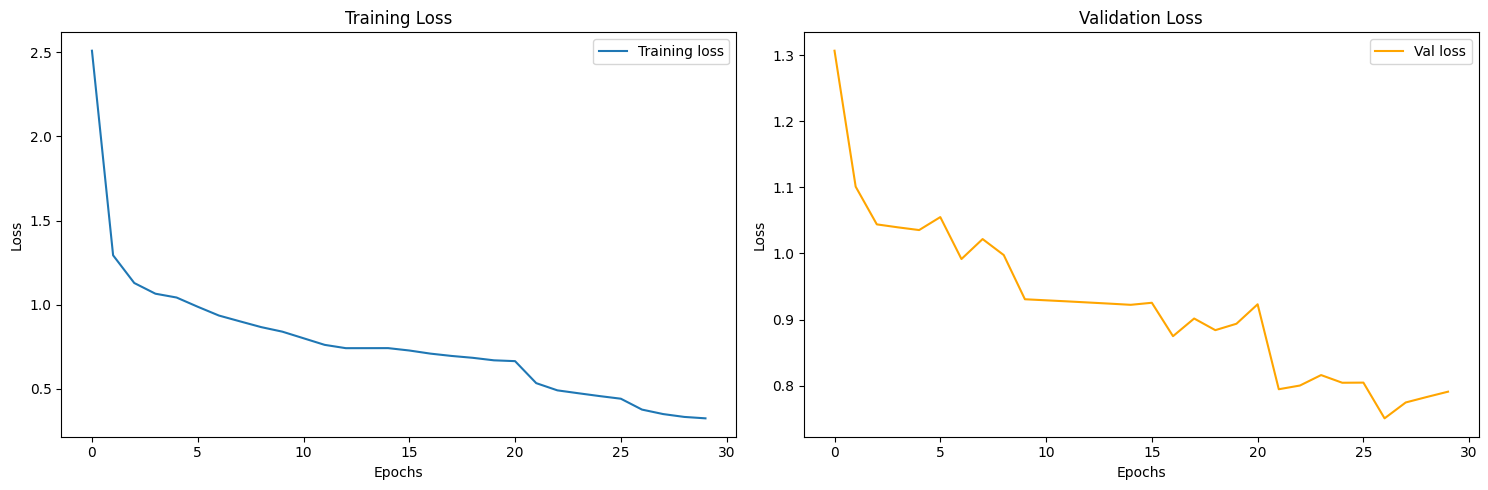

In [3]:
train_losses = [
    2.5098, 1.2933, 1.1286, 1.065, 1.0423, 0.9874, 0.9352, 0.9005, 0.8663, 0.8393,
    0.8001, 0.7608, 0.7411, 0.7412, 0.7414, 0.7273, 0.7087, 0.6949, 0.6838, 0.6689,
    0.664, 0.5332, 0.4903, 0.473, 0.4562, 0.4406, 0.3759, 0.3493, 0.3323, 0.3239
]

val_losses = [
    1.3065, 1.101, 1.044, 1.0395, 1.0354, 1.055, 0.9916, 1.0218, 0.9976, 0.9308,
    0.9292, 0.9276, 0.9259, 0.9242, 0.9224, 0.9255, 0.8750, 0.9017, 0.8841, 0.8938,
    0.9232, 0.7948, 0.8004, 0.8162, 0.8046, 0.8048, 0.7508, 0.7748, 0.7831, 0.7911
]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(train_losses, label="Training loss")
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(val_losses, label="Val loss", color="orange")
axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.show()

In [2]:
checkpoint = torch.load('ocr_crnn.pt')
model.load_state_dict(checkpoint['model_state_dict'])

NameError: name 'model' is not defined

In [ ]:
val_loss = evaluate(model, val_loader, criterion, device)
test_loss = evaluate(model, test_loader , criterion, device)

print ("Evaluation on val/test dataset")
print ("Val loss: ", val_loss)
print ("Test loss: ", test_loss)

# save_model_path = "ocr_crnn.pt"
# torch.save(model.state_dict(), save_model_path)

Evaluation on val/test dataset
Val loss:  0.9457747043131258
Test loss:  0.9229221038818359


In [20]:
def predict(model, img):
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        print(outputs)
        
def decode_label(encoded_sequences, idx_to_char, blank_char="-"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        for idx, token in enumerate(seq):
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    decoded_label.append(char)

        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences

From tensor([[59,  1,  1, 46, 46, 40, 48,  1, 42,  1, 55, 62,  1,  1]], device='cuda:0') to ['vickery']
From tensor([[3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0') to ['1']
From tensor([[19,  1,  1,  1,  1, 12,  1,  1, 29,  1,  1, 22,  1,  1]], device='cuda:0') to ['HARK']
From tensor([[13,  1,  1,  1,  1, 42,  1, 49,  1,  1, 55,  1,  1,  1]], device='cuda:0') to ['Belr']
From tensor([[30,  1,  1, 12, 23,  1, 23,  1, 19,  1, 12, 14,  1,  1]], device='cuda:0') to ['SALLHAC']
From tensor([[16,  1, 50,  1, 39, 55, 38,  1, 57, 42,  1,  1,  1,  1]], device='cuda:0') to ['Embrate']
From tensor([[11,  1,  1,  1,  8,  1, 55,  1,  1,  8,  1,  3,  1,  1]], device='cuda:0') to ['96r61']
From tensor([[17,  1,  1,  1,  1,  1, 29,  1,  1, 26,  1,  1,  1,  1]], device='cuda:0') to ['FRO']
From tensor([[41,  1,  1,  1,  1,  1,  1,  1, 58,  1,  1, 56,  1,  1]], device='cuda:0') to ['dus']
From tensor([[12,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]], device='cuda:0') to ['A']
Fr

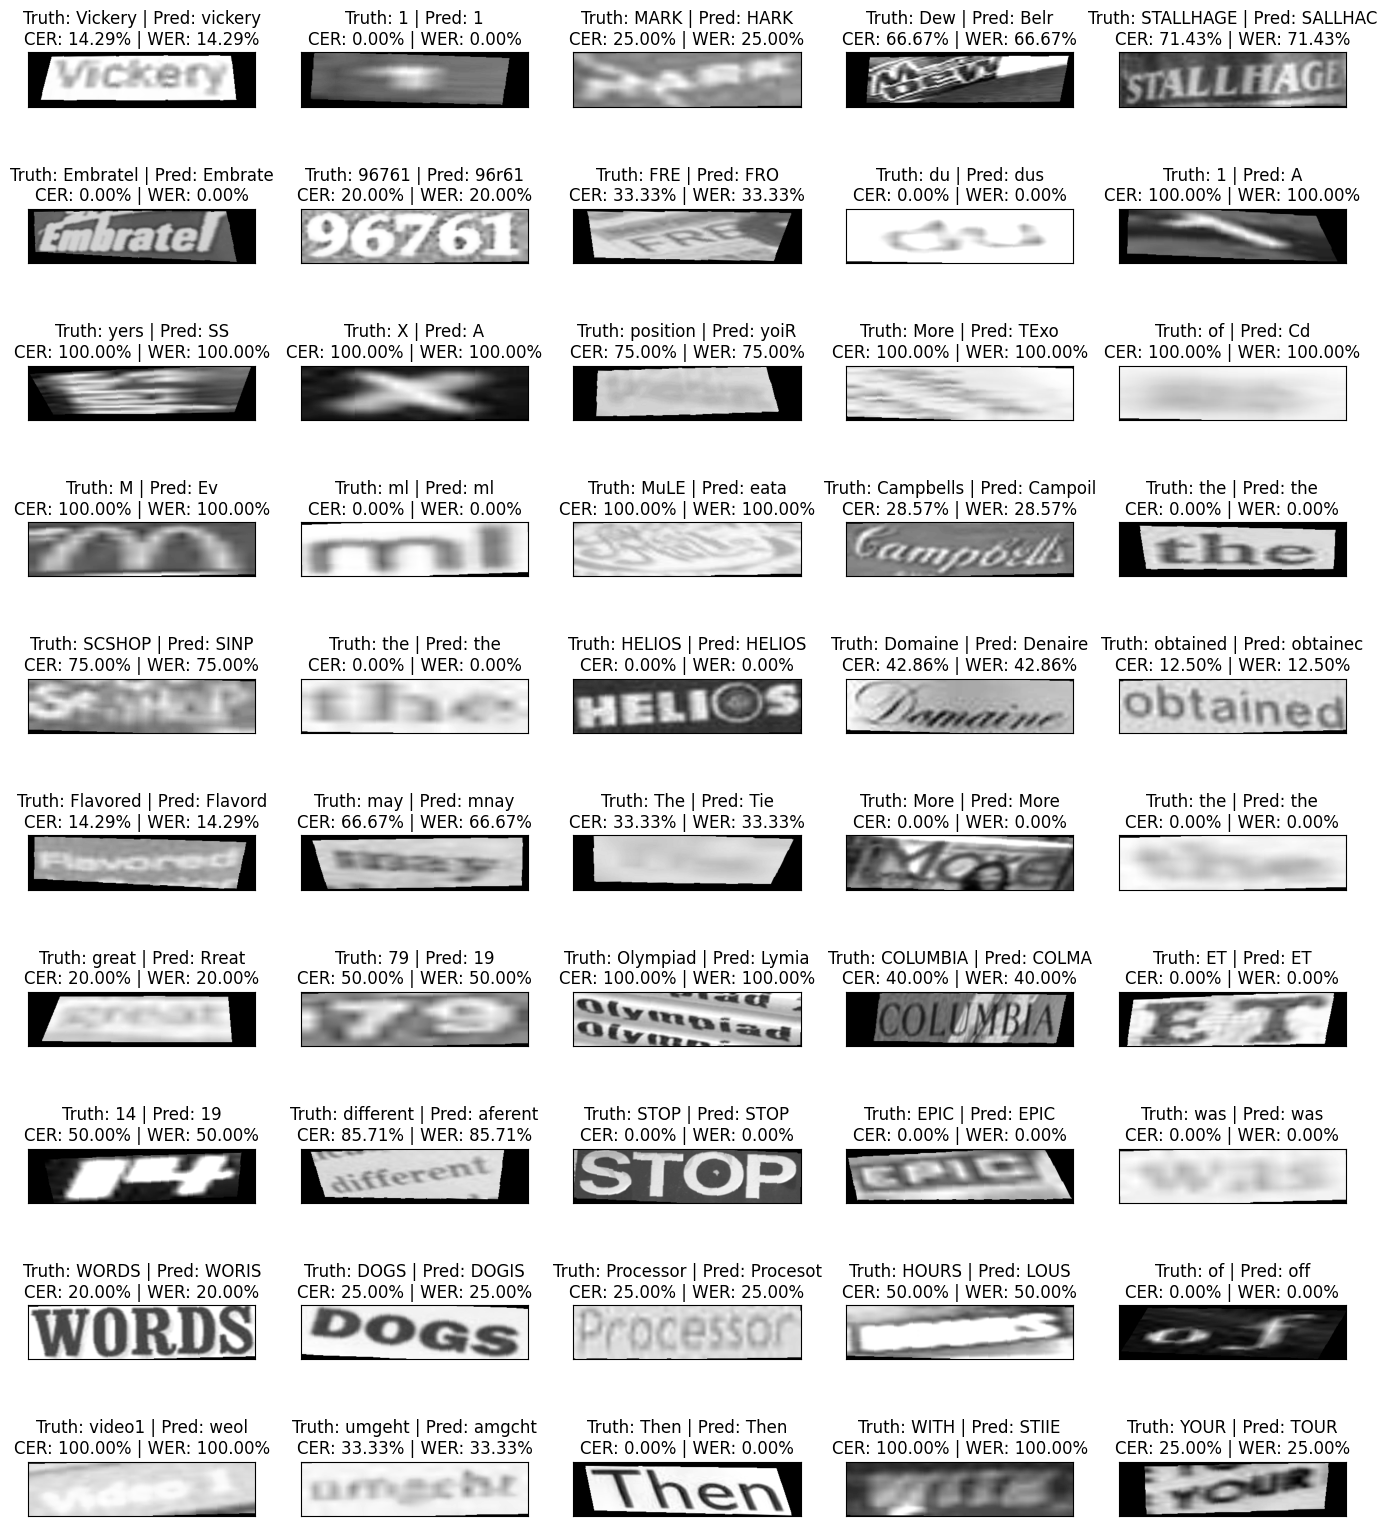

In [51]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(val_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode_label([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

From tensor([[21,  1,  1,  1,  1,  1,  1,  1, 52,  1,  1,  1,  1,  1]], device='cuda:0') to ['Jo']
From tensor([[30,  1,  1,  1,  1,  1,  1,  1,  1,  1, 42,  1,  1,  1]], device='cuda:0') to ['Se']
From tensor([[ 1,  1,  1,  1,  1,  1, 16,  1,  1,  1,  1,  1,  1,  1]], device='cuda:0') to ['E']
From tensor([[ 1,  1,  1,  1,  1, 12,  1,  1, 15,  1,  1,  1,  1,  1]], device='cuda:0') to ['AD']
From tensor([[ 1,  1,  1, 32,  1, 27,  1,  1, 12,  1, 23,  1, 14,  1]], device='cuda:0') to ['UPALC']
From tensor([[57,  1,  1,  1,  1,  1, 46,  1, 52,  1,  1,  1,  1,  1]], device='cuda:0') to ['tio']
From tensor([[28,  1,  1,  1,  1, 58,  1,  1, 46, 40,  1, 48,  1,  1]], device='cuda:0') to ['Quick']
From tensor([[ 1,  1,  1,  1,  1,  1, 52,  1, 57,  1,  1,  1,  1,  1]], device='cuda:0') to ['ot']
From tensor([[57,  1,  1,  1,  1, 51,  1,  1,  1,  1, 42,  1,  1,  1]], device='cuda:0') to ['tne']
From tensor([[26,  1,  1,  1,  1,  1,  1,  1, 17,  1,  1,  1, 31,  1]], device='cuda:0') to ['OFT']
Fr

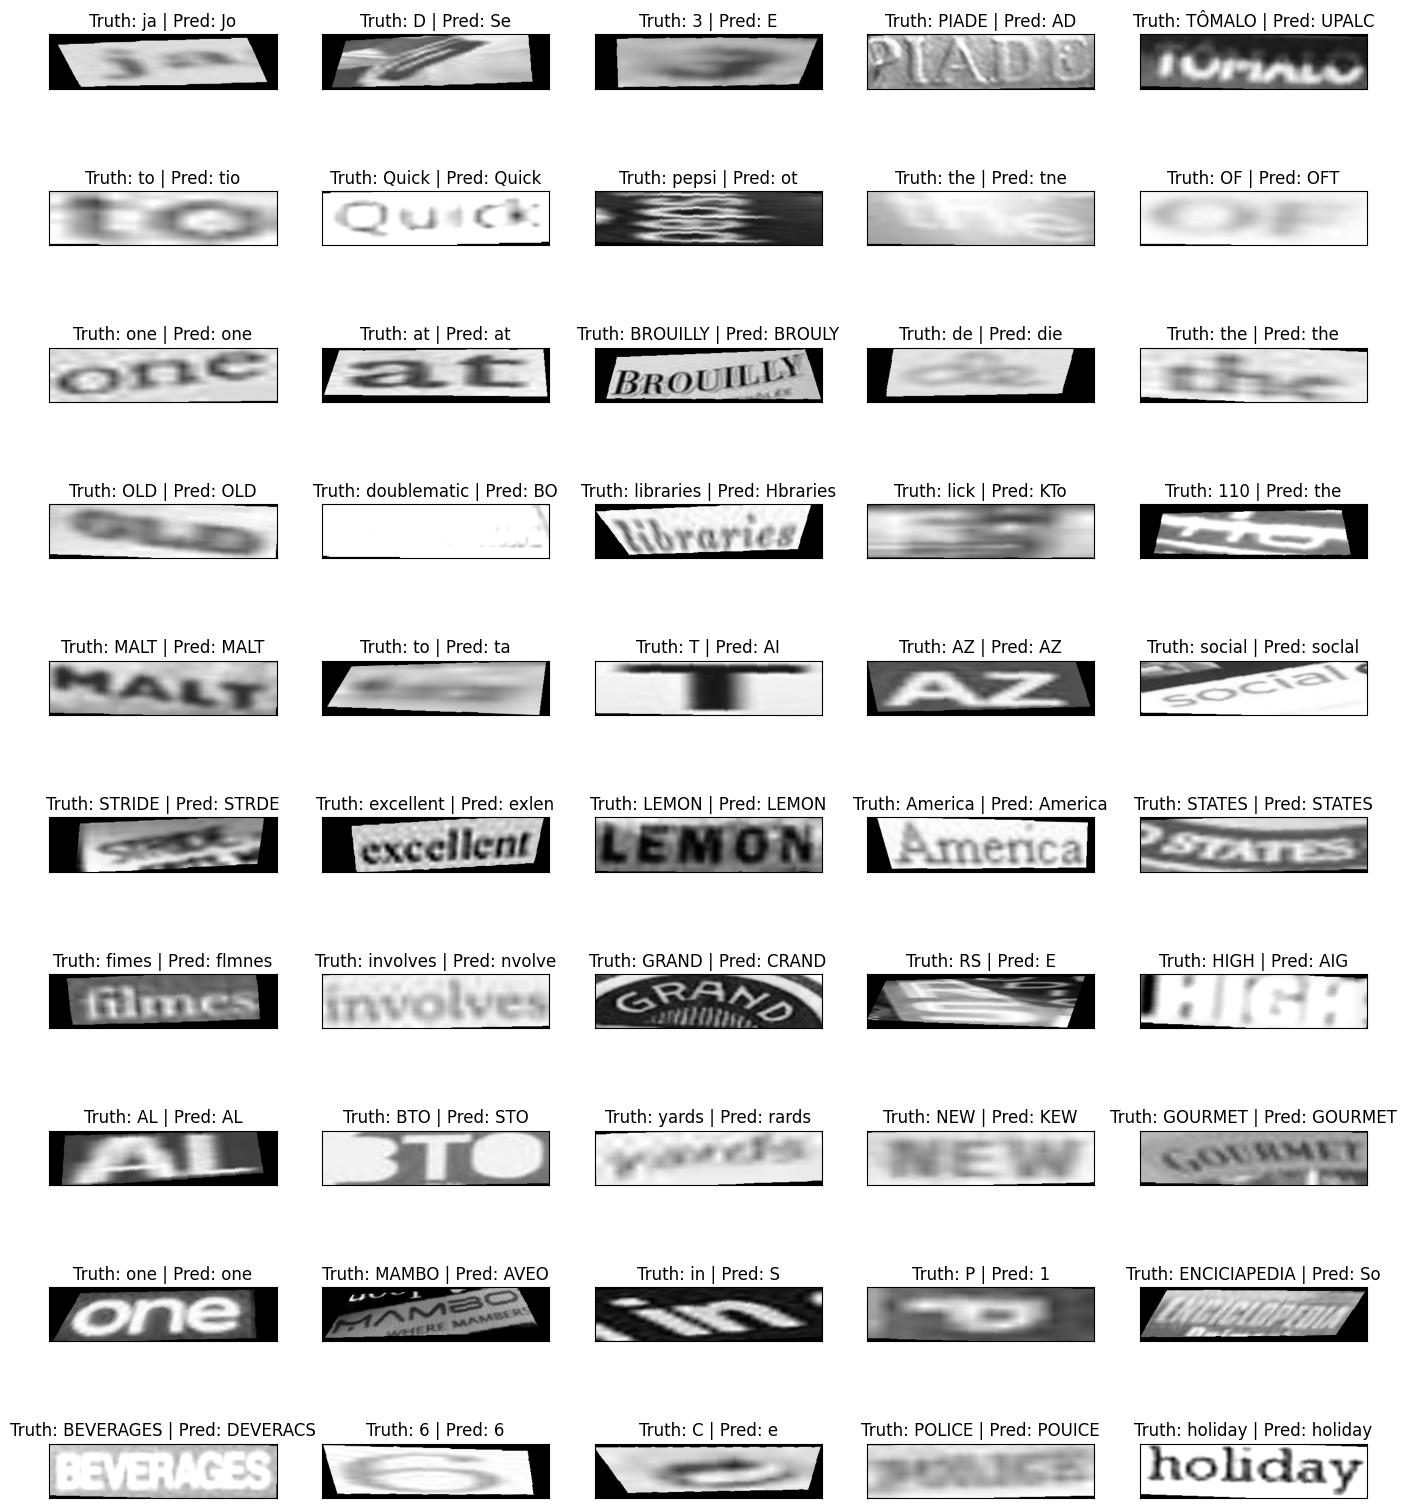

In [42]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(test_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode_label([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

In [27]:
y_pred = []
y_test = []

for i in tqdm(range(len(test_dataset)), desc='Predicting', leave=False):
    img, label, label_len = test_dataset[i]
    img = img.to(device)
    label = label.to(device)
    label= decode_label([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    y_pred.append(pred_text)
    y_test.append(label)

In [28]:
pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [34]:
from jiwer import wer, cer

print("CER:", cer(y_test, y_pred))
print("WER:", wer(y_test, y_pred))

CER: 0.43330199666053965
WER: 0.683875


In [35]:
def exact_match_accuracy(preds, targets):
    correct = sum(p == t for p, t in zip(preds, targets))
    total = len(targets)
    return correct / total
accuracy = exact_match_accuracy(y_pred, y_test)
print(f"Exact match accuracy: {accuracy:.2%}")

Exact match accuracy: 31.61%
